Epoch 1/20


C:\Users\remyd\AppData\Local\Temp\ipykernel_20040\552712125.py:32: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  temperature_data = temperature_data.iloc[:, 3:].mean().reset_index()
D:\Anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 1.0675 - mae: 0.9769 - val_loss: 0.5268 - val_mae: 0.7071
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.6125 - mae: 0.7173 - val_loss: 0.3957 - val_mae: 0.5992
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3794 - mae: 0.5727 - val_loss: 0.2925 - val_mae: 0.4940
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2396 - mae: 0.4314 - val_loss: 0.2153 - val_mae: 0.3901
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1512 - mae: 0.3270 - val_loss: 0.1664 - val_mae: 0.2980
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0957 - mae: 0.2445 - val_loss: 0.1421 - val_mae: 0.2726
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1113 - mae: 0.2917 - val_loss: 0.1307 - val_mae: 0.2653
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1353 - mae: 0.3372 - val_loss: 0.1278 - val_mae: 0.2742
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1296 - mae: 0.3297 - val_loss: 

D:\Anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


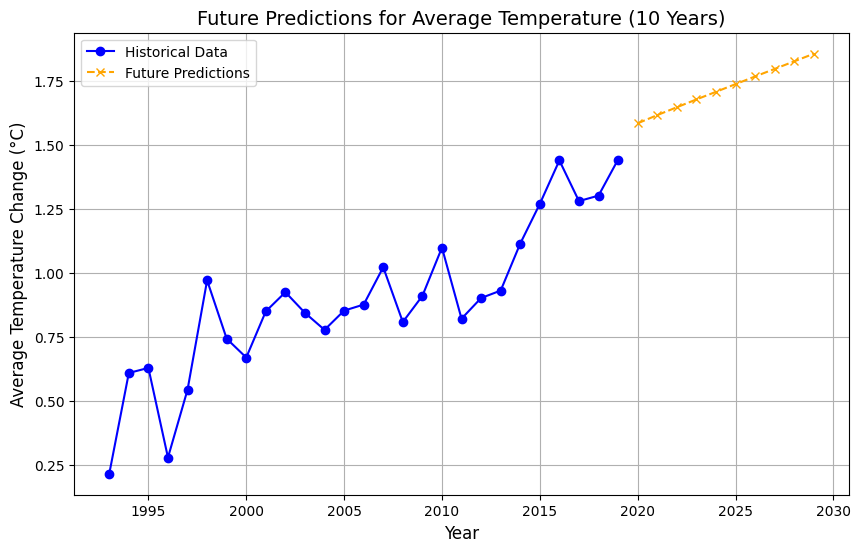

In [15]:
# Manipulation des données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Modélisation avec un réseau de neurones
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Recharger les jeux de données bruts
co2_emissions = pd.read_csv('data/co2_emissions_kt_by_country.csv')
sea_level = pd.read_csv('data/sealevel.csv')
climate_indicators = pd.read_csv('data/climate_change_indicators.csv')

# Prétraitement des données
# Nettoyer et aligner les années pour chaque dataset

# CO2 emissions: Garder les années globales
co2_emissions_cleaned = co2_emissions.groupby("year")["value"].sum().reset_index()
co2_emissions_cleaned.columns = ["Year", "CO2_Emissions"]

# Sea level: Garder la moyenne annuelle de GMSL
sea_level_cleaned = sea_level.groupby("Year")["GMSL_noGIA"].mean().reset_index()
sea_level_cleaned.columns = ["Year", "Sea_Level"]

# Climate indicators: Garder les températures moyennes pour les années disponibles
temperature_data = climate_indicators[climate_indicators["Indicator"].str.contains("Temperature change", case=False)]
temperature_data = temperature_data.iloc[:, 3:].mean().reset_index()
temperature_data.columns = ["Year", "Average_Temperature"]
temperature_data["Year"] = temperature_data["Year"].str.extract('(\d+)').astype(int)

# Fusionner les datasets
merged_data = co2_emissions_cleaned.merge(sea_level_cleaned, on="Year", how="inner")
merged_data = merged_data.merge(temperature_data, on="Year", how="inner")

# Préparation des données pour le réseau de neurones
X = merged_data[["CO2_Emissions", "Sea_Level"]]
y = merged_data["Average_Temperature"]

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Création du modèle de réseau de neurones
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Couche cachée avec 128 neurones
model.add(Dense(64, activation='tanh'))  # Couche cachée avec tanh
model.add(Dense(32, activation='relu'))  # Couche cachée avec ReLU
model.add(Dense(1))  # Couche de sortie

# Compilation du modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, verbose=1)

# Évaluation du modèle
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error on Test Set: {mae}")

# Générer des données futures pour les 10 prochaines années
future_years = np.arange(merged_data["Year"].max() + 1, merged_data["Year"].max() + 11)
future_co2_emissions = np.linspace(merged_data["CO2_Emissions"].iloc[-1] * 1.01, merged_data["CO2_Emissions"].iloc[-1] * 1.1, 10)
future_sea_level = np.linspace(merged_data["Sea_Level"].iloc[-1] * 1.01, merged_data["Sea_Level"].iloc[-1] * 1.1, 10)

# Ajouter du bruit pour réduire la linéarité
noise_co2 = np.random.normal(0, 0.02, size=future_co2_emissions.shape)
noise_sea_level = np.random.normal(0, 0.02, size=future_sea_level.shape)
future_co2_emissions_noisy = future_co2_emissions + noise_co2
future_sea_level_noisy = future_sea_level + noise_sea_level

# Recréer les données futures avec bruit
future_data = np.column_stack((future_co2_emissions_noisy, future_sea_level_noisy))
future_data_scaled = scaler.transform(future_data)

# Prédire les températures moyennes futures avec le modèle de réseau de neurones
future_temperature_predictions = model.predict(future_data_scaled)

# Afficher les prédictions futures dans un graphique
plt.figure(figsize=(10, 6))
plt.plot(merged_data["Year"], merged_data["Average_Temperature"], label="Historical Data", marker="o", color="blue")
plt.plot(future_years, future_temperature_predictions, label="Future Predictions", marker="x", linestyle="--", color="orange")
plt.title("Future Predictions for Average Temperature (10 Years)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Temperature Change (°C)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
